In [1]:
import tensorflow as tf
import tensorflow.contrib.slim as slim
import numpy as np
import os
from scipy.misc import imread,imresize
from random import shuffle
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from tqdm import tqdm
import mobilenet_v2
import warnings
warnings.filterwarnings('ignore')
tf.__version__

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


'1.5.0'

In [2]:
checkpoint_name = 'mobilenet_v2_1.0_224'
checkpoint = checkpoint_name + '.ckpt'
batch_size = 32
learning_rate = 1e-3
dir_data = ['husein','negative']

In [3]:
data_X, data_Y = [], []
for no, i in enumerate(dir_data):
    dirs = ['%s/%s'%(i,n) for n in os.listdir(i)]
    data_X += dirs
    data_Y += [no]*len(dirs)
    
c = list(zip(data_X, data_Y))
shuffle(c)
data_X, data_Y = zip(*c)

In [4]:
def _pairwise_distances(embeddings, squared=False):
    dot_product = tf.matmul(embeddings, tf.transpose(embeddings))
    square_norm = tf.diag_part(dot_product)
    distances = tf.expand_dims(square_norm, 1) - 2.0 * dot_product + tf.expand_dims(square_norm, 0)
    distances = tf.maximum(distances, 0.0)

    if not squared:
        mask = tf.to_float(tf.equal(distances, 0.0))
        distances = distances + mask * 1e-16
        distances = tf.sqrt(distances)
        distances = distances * (1.0 - mask)

    return distances


def _get_anchor_positive_triplet_mask(labels):
    indices_equal = tf.cast(tf.eye(tf.shape(labels)[0]), tf.bool)
    indices_not_equal = tf.logical_not(indices_equal)
    labels_equal = tf.equal(tf.expand_dims(labels, 0), tf.expand_dims(labels, 1))
    mask = tf.logical_and(indices_not_equal, labels_equal)

    return mask


def _get_anchor_negative_triplet_mask(labels):
    labels_equal = tf.equal(tf.expand_dims(labels, 0), tf.expand_dims(labels, 1))
    mask = tf.logical_not(labels_equal)

    return mask


def _get_triplet_mask(labels):
    indices_equal = tf.cast(tf.eye(tf.shape(labels)[0]), tf.bool)
    indices_not_equal = tf.logical_not(indices_equal)
    i_not_equal_j = tf.expand_dims(indices_not_equal, 2)
    i_not_equal_k = tf.expand_dims(indices_not_equal, 1)
    j_not_equal_k = tf.expand_dims(indices_not_equal, 0)

    distinct_indices = tf.logical_and(tf.logical_and(i_not_equal_j, i_not_equal_k), j_not_equal_k)

    label_equal = tf.equal(tf.expand_dims(labels, 0), tf.expand_dims(labels, 1))
    i_equal_j = tf.expand_dims(label_equal, 2)
    i_equal_k = tf.expand_dims(label_equal, 1)

    valid_labels = tf.logical_and(i_equal_j, tf.logical_not(i_equal_k))
    mask = tf.logical_and(distinct_indices, valid_labels)

    return mask


def batch_all_triplet_loss(labels, embeddings, margin, squared=False):
    pairwise_dist = _pairwise_distances(embeddings, squared=squared)

    # shape (batch_size, batch_size, 1)
    anchor_positive_dist = tf.expand_dims(pairwise_dist, 2)
    assert anchor_positive_dist.shape[2] == 1, "{}".format(anchor_positive_dist.shape)
    # shape (batch_size, 1, batch_size)
    anchor_negative_dist = tf.expand_dims(pairwise_dist, 1)
    assert anchor_negative_dist.shape[1] == 1, "{}".format(anchor_negative_dist.shape)

    triplet_loss = anchor_positive_dist - anchor_negative_dist + margin

    mask = _get_triplet_mask(labels)
    mask = tf.to_float(mask)
    triplet_loss = tf.multiply(mask, triplet_loss)

    # Remove negative losses (i.e. the easy triplets)
    triplet_loss = tf.maximum(triplet_loss, 0.0)

    # Count number of positive triplets (where triplet_loss > 0)
    valid_triplets = tf.to_float(tf.greater(triplet_loss, 1e-16))
    num_positive_triplets = tf.reduce_sum(valid_triplets)
    num_valid_triplets = tf.reduce_sum(mask)
    fraction_positive_triplets = num_positive_triplets / (num_valid_triplets + 1e-16)

    # Get final mean triplet loss over the positive valid triplets
    triplet_loss = tf.reduce_sum(triplet_loss) / (num_positive_triplets + 1e-16)

    return triplet_loss, fraction_positive_triplets

In [5]:
tf.reset_default_graph()
sess = tf.InteractiveSession()
X = tf.placeholder(tf.float32,[None,224,224,3])
Y = tf.placeholder(tf.int64, [None])
images = X
images = tf.map_fn(lambda image: tf.image.per_image_standardization(image), images)
with tf.contrib.slim.arg_scope(mobilenet_v2.training_scope(is_training=True)):
    logits, endpoints = mobilenet_v2.mobilenet(images,num_classes=2)
        
cost, fraction = batch_all_triplet_loss(Y, logits, margin=0.5, squared=False)
optimizer = tf.train.AdamOptimizer(1e-3).minimize(cost)

sess.run(tf.global_variables_initializer())
var_lists = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope = 'MobilenetV2')
var_lists_without_logits = [i for i in var_lists if i.name.find('Conv2d_1c') < 0]
saver = tf.train.Saver(var_list = var_lists_without_logits)
saver.restore(sess, checkpoint)

INFO:tensorflow:Restoring parameters from mobilenet_v2_1.0_224.ckpt


In [6]:
batch_size = 16
for i in range(10):
    total_loss = 0
    for index in range(0,len(data_X),batch_size):
        batch_images = data_X[index:min(index+batch_size,len(data_X))]
        batch_x = np.zeros((len(batch_images),224,224,3))
        for k in range(len(batch_images)):
            batch_x[k] = imresize(imread(data_X[index+k]), (224,224))
        batch_y = data_Y[index:min(index+batch_size,len(data_X))]
        loss, _ = sess.run([cost,optimizer],feed_dict={X:batch_x,Y:batch_y})
        total_loss += loss
    total_loss /= len(data_X)
    print('epoch: %d, avg cost: %f'%(i+1,total_loss))

epoch: 1, avg cost: 0.190740
epoch: 2, avg cost: 0.059936
epoch: 3, avg cost: 0.025719
epoch: 4, avg cost: 0.065863
epoch: 5, avg cost: 0.047274
epoch: 6, avg cost: 0.045406
epoch: 7, avg cost: 0.025197
epoch: 8, avg cost: 0.015283
epoch: 9, avg cost: 0.000000
epoch: 10, avg cost: 0.000000


In [7]:
embedded = []
for index in range(0,len(data_X),batch_size):
    batch_images = data_X[index:min(index+batch_size,len(data_X))]
    batch_x = np.zeros((len(batch_images),224,224,3))
    for k in range(len(batch_images)):
        batch_x[k] = imresize(imread(data_X[index+k]), (224,224))
    embedded.append(logits.eval({X:batch_x}))
embedded = np.concatenate(embedded,axis=0)

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

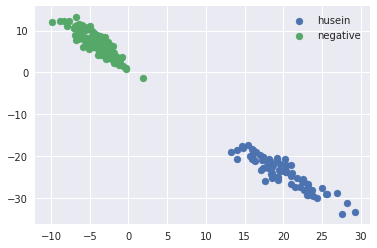

In [9]:
data_Y = np.array(data_Y)
for no,i in enumerate(np.unique(data_Y)):
    plt.scatter(embedded[data_Y==i,0],embedded[data_Y==i,1],label=dir_data[no])
plt.legend()
plt.show()